In [2]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import matplotlib.pyplot as plt

# Building DAG Hierarchy

**Goal: Group terms and find common name to create a hierarchy of DAG nodes from broad down to specific.**

Import Data
1. `dag_df` - Standardized DAG dataframe from workshop
2. `concept_df` - Athena concept dataframe containing all the athena ids, concept codes, and concept names
3. `concept_relationship_df` - Athena dataframe containing the relationships between all the concepts
4. `concept_ancestor_df` - Athena dataframe containing information on the ancestors of terms (unfortunately seems incomplete)

In [3]:
dag_df = pd.read_csv('../data/DAGs_standardized.csv', dtype={'Exposure': str, 'Outcome':str})
concept_df = pd.read_csv('../Standardization/athena_vocabulary/CONCEPT.csv', sep='\t', dtype={'concept_code': str, 'concept_id': str}, low_memory=False)
concept_relationship_df = pd.read_csv('../Standardization/athena_vocabulary/CONCEPT_RELATIONSHIP.csv', sep='\t', dtype={'concept_id_1':str, 'concept_id_2': str}, low_memory=False)
concept_ancestor_df = pd.read_csv('../Standardization/athena_vocabulary/CONCEPT_ANCESTOR.csv', sep='\t',dtype={'ancestor_concept_id': str, 'descendant_concept_id': str}, low_memory=False)

Get set of terms

In [4]:
from hierarchy_functions import get_unique_coded_terms

my_terms = get_unique_coded_terms(dag_df)

c:\Users\Leo\miniconda3\envs\wise-dag-ml\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dictionary to convert codes to names

In [5]:
code_to_name = dict(zip(concept_df["concept_id"], concept_df["concept_name"]))
name_to_code = dict(zip(concept_df["concept_name"], concept_df["concept_id"]))
my_terms_written = [code_to_name[code] for code in my_terms]

### **Approach 1:** Using the parent and child relationships part of the OHDSI CDM / SNOMED CT ontology

First, let's explore what happens if we condense all child terms by associating them directly with their respective parent (root) terms within the terms that were part of the DAGs.

In [6]:
from hierarchy_functions import analyze_snomed_hierarchy

analysis_result = analyze_snomed_hierarchy(concept_ancestor_df, my_terms)
analysis_result

{'root_term_count': '129 out of 182 terms are root nodes',
 'average_children_per_root': 0.1,
 'example_root_with_children': {'root': '4194238', 'children': ['4283095']}}

In [7]:
# Example
print('Root term:', code_to_name[analysis_result['example_root_with_children']['root']])
print('Children:', [code_to_name[i] for i in analysis_result['example_root_with_children']['children']])

Root term: Endarterectomy
Children: ['Carotid endarterectomy']


It seems that even after doing so there are still a lot of different unique terms and we have to further group these into more broad categories to not overwhelm researchers. For this we will consider calcualting the distances from all the nodes to each other through a common ancestor node. This is important as nodes can have different parent terms and might otherwise link horizontally in a zig zag pattern instead of through a common ancestor higher up in the hierarchy.

There are a variety of relationship types available in the OHDSI Athena database. For now, we are using the "Subsumes" relationships that are the relationships that connect a parent term to a child term in the SNOMED CT hierarchy. However, more potentially useful relationship types are available like can be seen below.

In [8]:
useful_relationship_ids = [
    "Is a",                     # Hierarchical relationship of SNOMED
    "Subsumes",
    "Finding site of",          # Links findings to anatomical sites
    "Interprets of",            # Links specific measurements to conditions
    "Causative agent of",       # Etiological link
    "Has due to",               # Etiology relationships
    "Due to of",
    "Asso finding of",
    "Pathology of",             # Links to pathological processes
    "Has dir morph",            # Direct morphology
    "Has asso morph",           # Associated morphology
    "Occurs before",            # Temporal relationship
    "Follows",                  # Temporal relationship
    "Has manifestation",        # Links findings to manifestations
    "Has complication"          # Links to complications
]

selected_relationship_ids = ["Subsumes"]

Creating a graph structure of the terms based on SNOMED CT hierachy.

In [9]:
from hierarchy_functions import create_SNOMED_CT_graph_based_on_terms

G = create_SNOMED_CT_graph_based_on_terms(my_terms, concept_df, concept_relationship_df, selected_relationship_ids)

Number of nodes in graph of relevant SNOMED CT terms: 768
Number of edges in graph of relevant SNOMED CT terms: 1177
All terms are present in the graph.


Computing the least common ancestor between any two nodes part of my_terms and then the distance between the two terms going through that LCA.

In [10]:
from hierarchy_functions import compute_lcas_and_distances

lca_results = compute_lcas_and_distances(my_terms, G)

What are the most common "least common ancestors" between terms?

In [11]:
from collections import Counter

lca_counts = Counter(lca_results[0].values())
lca_counts_df = pd.DataFrame.from_dict(lca_counts, orient='index').reset_index()
lca_counts_df.columns = ['athena_code', 'count']
lca_counts_df = lca_counts_df.sort_values('count', ascending=False)
lca_counts_df['concept_name'] = [code_to_name[i] for i in lca_counts_df['athena_code']]
lca_counts_df.head(10)

,athena_code,count,concept_name
2,4008453,10707,SNOMED CT Concept
0,441840,2992,Clinical finding
1,4274025,697,Disease
36,134057,343,Disorder of cardiovascular system
18,4322976,298,Procedure
3,4180628,238,Disorder of body system
17,4029205,163,Procedure by method
27,4181663,114,Observable entity
5,4047779,94,Disorder by body site
49,321588,85,Heart disease


Creating a distance matrix for the terms.

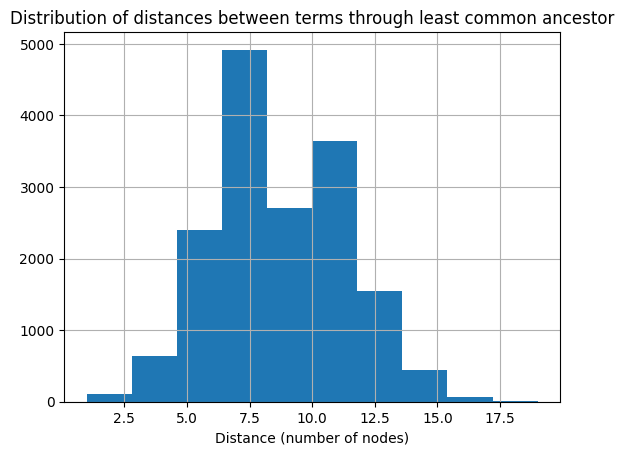

In [12]:
terms = sorted(my_terms)
distance_matrix = pd.DataFrame(index=terms, columns=terms, data=float('inf'))

for (term1, term2), distance in lca_results[1].items():
    distance_matrix.at[term1, term2] = distance
    distance_matrix.at[term2, term1] = distance
for term in my_terms:
    distance_matrix.at[term, term] = 0

distance_matrix.to_csv('snomed_distance_matrix.csv')
pd.Series(lca_results[1].values()).hist()
plt.title('Distribution of distances between terms through least common ancestor')
plt.xlabel('Distance (number of nodes)');

In [13]:
from hierarchy_functions import graph_distance_matrix_in_3d

graph_distance_matrix_in_3d(distance_matrix, [code_to_name[i] for i in terms])

### **Approach 2:** Using word embeddings

1. **SapBERT** - https://huggingface.co/cambridgeltl/SapBERT-from-PubMedBERT-fulltext
2. **SNOMED CT BioBERT** - https://huggingface.co/KimTang/SNOMEDCT_BioBERT

In [14]:
snomed_biobert = "KimTang/SNOMEDCT_BioBERT"
sapbert = "cambridgeltl/SapBERT-from-PubMedBERT-fulltext"

In [15]:
from hierarchy_functions import get_embeddings

embeddings, embedding_names, embedding_matrix = get_embeddings(my_terms_written, sapbert)
embeddings_2, embedding_names_2, embedding_matrix_2 = get_embeddings(my_terms_written, snomed_biobert)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [16]:
from hierarchy_functions import graph_reduced_in_3d

graph_reduced_in_3d(embedding_matrix, embedding_names, title='SapBERT Embeddings in 3D')

In [17]:
graph_reduced_in_3d(embedding_matrix_2, embedding_names_2, title='SNOMEDCT_BioBERT Embeddings in 3D')

### **Approach 3:**

Use SNOMED CT Hierarchy, then use embeddings to map terms that dont link to main tree to closest term within that tree.

1. Select SNOMED CT subset that carries more semantic meaning (e.g. clinical finding)
2. Cluster concepts within this subset
    a) Group descendants with their ancestors
    b) Cluster root ancestors
3. Get embeddings for all SNOMED CT terms in clinical finding tree
4. Compute similarity of remaining terms with these, pick closest and add to cluster

In [ ]:
import networkx as nx
from hierarchy_functions import find_lca_and_distance, compute_lcas_and_distances
from collections import defaultdict

In [41]:
my_terms_filtered = set(concept_df[concept_df.concept_id.isin(my_terms)&concept_df.concept_class_id.isin(['Clinical Finding','Disorder'])].concept_id)

In [22]:
G_test = create_SNOMED_CT_graph_based_on_terms(my_terms_filtered, concept_df, concept_relationship_df, selected_relationship_ids)

Number of nodes in graph of relevant SNOMED CT terms: 430
Number of edges in graph of relevant SNOMED CT terms: 742
All terms are present in the graph.


In [ ]:
# precompute least common ancestors and distances between already existing nodes
lca_distances = compute_lcas_and_distances(my_terms_filtered, G_test)

remaining_terms = my_terms_filtered.copy()
hierarchy = defaultdict(list)
processed_pairs = set()  # Track processed pairs to avoid infinite loops

def has_descendants(term, remaining_terms, graph):
    """Check if a term has descendants in the remaining terms."""
    descendants = nx.descendants(graph, term)
    return bool(descendants & set(remaining_terms))

while len(remaining_terms) > 1:
    shortest_distance = float("inf")
    best_pair = None
    best_lca = None

    # Find the best pair of terms based on distance
    for node1 in remaining_terms:
        for node2 in remaining_terms:
            if node1 == node2:
                continue
            key = frozenset({node1, node2})
            if key in processed_pairs:
                continue
            if key not in lca_distances[1]:
                lca, distance = find_lca_and_distance(G_test, node1, node2)
                lca_distances[0][key] = lca
                lca_distances[1][key] = distance
            dist = lca_distances[1][key]

            # Update the best pair if this distance is shorter
            if dist < shortest_distance:
                shortest_distance = dist
                best_pair = (node1, node2)
                best_lca = lca_distances[0][key]

    if best_pair is None:
        break
    
    hierarchy[best_lca].append(best_pair)    
    processed_pairs.add(frozenset(best_pair))

    # Replace grouped nodes with their LCA if they no longer have descendants
    for node in best_pair:
        if not has_descendants(node, remaining_terms, G_test):
            remaining_terms.remove(node)
    remaining_terms.add(best_lca)

In [98]:
def hierarchy_to_graph(hierarchy, original_terms):
    """
    Convert a hierarchy dictionary to a directed graph, removing duplicates and self-references.
    Adds a 'type' attribute to distinguish between original and LCA nodes.
    """
    graph = nx.DiGraph()

    # Iterate over the hierarchy
    for lca, pairs in hierarchy.items():
        # Add the LCA node and mark it as an 'lca'
        if lca not in graph:
            graph.add_node(lca, type="lca")

        for pair in pairs:
            for node in pair:
                # Add the original terms or nodes if not already added
                if node not in graph:
                    node_type = "original" if node in original_terms else "lca"
                    graph.add_node(node, type=node_type)

                # Add edges, avoiding self-references
                if lca != node:
                    if not graph.has_edge(lca, node):
                        graph.add_edge(lca, node)

    return graph

In [100]:
graph = hierarchy_to_graph(hierarchy, my_terms_filtered)

In [101]:
def prune_redundant_edges(graph):
    """Remove redundant edges that create shortcuts in the hierarchy."""
    edges_to_remove = set()

    for node in graph.nodes:
        descendants = nx.descendants(graph, node)
        for descendant in descendants:
            for intermediate in graph.successors(node):
                if intermediate in descendants and graph.has_edge(intermediate, descendant):
                    edges_to_remove.add((node, descendant))

    graph.remove_edges_from(edges_to_remove)
    return graph

pruned_graph = prune_redundant_edges(graph)

In [103]:
def replace_nodes_with_names(graph, mapping):
    """Replace node codes with names based on a mapping dictionary while preserving attributes."""

    new_graph = nx.DiGraph()

    # Add nodes with attributes, replacing codes with names
    for node, attrs in graph.nodes(data=True):
        new_node = mapping.get(node, node)  # Replace code with name if mapping exists
        new_graph.add_node(new_node, **attrs)  # Preserve attributes

    # Add edges, replacing codes with names
    for u, v, attrs in graph.edges(data=True):
        new_u = mapping.get(u, u)
        new_v = mapping.get(v, v)
        new_graph.add_edge(new_u, new_v, **attrs)  # Preserve edge attributes

    return new_graph

graph_with_names = replace_nodes_with_names(graph, code_to_name)

In [104]:
nx.write_gexf(graph_with_names, 'snomed_grouping.gexf')

for other terms, first check if there is a different relationshiptype that links it, if not then use language model